# Dataloader for Contrastive Loss

This notebook implements the dataloader needed for training the Siamese network later.

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1" #to suppress some unnecessary warnings
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import random
from Utilities import DataLoaderContrastive, get_dataset_with_prefetching

2024-11-28 13:33:18.933525: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732789998.949766   31959 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732789998.954780   31959 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Load all the classes and their images.

In [2]:
dataset_root_path = os.path.join('Data', 'LFW', 'lfw_funneled')
classes_paths = []

for dir in os.scandir(dataset_root_path):
    classes_paths.append([])
    
    for file in os.scandir(dir.path):
        if file.is_file():
            classes_paths[-1].append(file.path)

print(f"{len(classes_paths)} classes.")

5749 classes.


## Data loader implementation

In [ ]:
class DataLoader(tf.keras.utils.Sequence):

    def __init__(self, dataset_path, batch_size, input_shape=(250, 250), *args, **kwargs):
        super().__init__(**kwargs)
        
        self.input_shape = input_shape
        self.batch_size = batch_size

        self.dataset_path = dataset_path
        self.classes_paths = []
        
        for dir in os.scandir(self.dataset_path):
            self.classes_paths.append([])
            
            for file in os.scandir(dir.path):
                if file.is_file():
                    self.classes_paths[-1].append(file.path)
        
        # calculate the total number of batches
        self.batches_num = np.ceil(len(self.classes_paths) / self.batch_size).astype(np.int32)
    
    def load_img(self, path):
        image = keras.preprocessing.image.load_img(path)
        image_arr = keras.preprocessing.image.img_to_array(image)
        return image_arr / 255
        
    # the training algorithm (model.fit()) will call this function to get the n'th batch of the dataset
    def __getitem__(self, n):
        
        paths_batch = self.classes_paths[n*self.batch_size : (n+1)*self.batch_size]

        X1 = np.zeros((self.batch_size, self.input_shape[1], self.input_shape[0], 3))
        X2 = np.zeros((self.batch_size, self.input_shape[1], self.input_shape[0], 3))
        Y = np.zeros((self.batch_size, 1))

        for i in range(self.batch_size):
            sample_class_1 = random.choice(paths_batch)
            sample_class_2 = random.choice(paths_batch)

            X1[i] = self.load_img(random.choice(sample_class_1))
            X2[i] = self.load_img(random.choice(sample_class_2))
            
            if sample_class_1 == sample_class_2:
                Y[i] = 1
            else:
                Y[i] = 0
        
        #Since the model has two inputs, X1 and X2 has to be grouped into a tuple.
        return (X1, X2), Y

    # returns the number of batches in the dataset
    def __len__(self):
        return self.batches_num
    
    # called at the end of the epoch
    def on_epoch_end(self):
        # shuffle the paths of images at the end of each epoch
        np.random.shuffle(self.classes_paths)

Test the **Data Loader**

In [3]:
train_loader = DataLoaderContrastive(dataset_path=dataset_root_path, batch_size=32, input_shape=(250, 250))

input batch shape is (2, 250, 250, 3)
output batch shape is (32, 1)
label is : 0.0


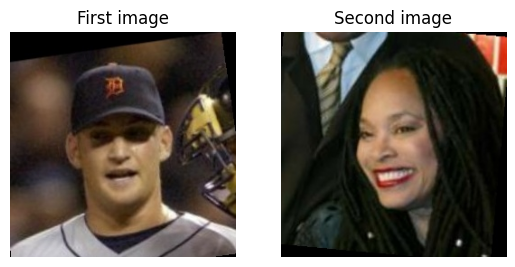

In [4]:
# get sample batch
(X1, X2), Y = train_loader[random.randint(0, len(train_loader)-1)]

# get sample pair
x1 = X1[random.randint(0, len(X1)-1)]
x2 = X2[random.randint(0, len(X2)-1)]
y_label = Y[random.randint(0, len(Y)-1)]

print(f"input batch shape is {np.concatenate([[x1], [x2]], axis = 0).shape}")
print(f"output batch shape is {Y.shape}")
print(f"label is : {y_label[0]}")

# show a sample image pair
plt.subplot(1, 2, 1)
plt.imshow(x1)
plt.axis('off')
plt.title("First image")

plt.subplot(1, 2, 2)
plt.imshow(x2)
plt.axis('off')
plt.title("Second image")

plt.show()

## Real Example

In [5]:
Input1 = keras.layers.Input(shape = (250, 250, 3))
Input2 = keras.layers.Input(shape = (250, 250, 3))
flatten1 = keras.layers.Flatten()(Input1)
flatten2 = keras.layers.Flatten()(Input2)
feature_vector = keras.layers.Concatenate()([flatten1, flatten2])
clf_head = keras.layers.Dense(32, 'relu')(feature_vector)
output = keras.layers.Dense(1, 'sigmoid')(clf_head)

model = keras.Model(inputs = [Input1, Input2], outputs = output)

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


I0000 00:00:1732790007.990270   31959 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5666 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:09:00.0, compute capability: 8.6


Note that the high accuracy is not due to the fact that the model is good. <br> 
It is rather because the model mostly outputs a 0 most of the time since the majority of examples are negative. 

To do:
* Fix the dataset imbalance

In [6]:
train_loader = DataLoaderContrastive(dataset_path=dataset_root_path, batch_size=32, input_shape=(250, 250))

model.fit(train_loader, epochs = 2)

Epoch 1/2


/home/thoalfeqar/anaconda3/envs/tf/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_1']. Received: the structure of inputs=('*', '*')
  warnings.warn(
I0000 00:00:1732790010.627807   32060 service.cc:148] XLA service 0x7e00cc003270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732790010.627832   32060 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
I0000 00:00:1732790010.795909   32060 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/180 ━━━━━━━━━━━━━━━━━━━━ 3:09 1s/step - accuracy: 0.0625 - loss: 0.7454

I0000 00:00:1732790011.001291   32060 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


180/180 ━━━━━━━━━━━━━━━━━━━━ 24s 128ms/step - accuracy: 0.9378 - loss: 7.6467
Epoch 2/2
180/180 ━━━━━━━━━━━━━━━━━━━━ 23s 129ms/step - accuracy: 0.9697 - loss: 0.2299


Test the model on an example:

In [7]:
(X1, X2), y = train_loader[0]
x1, x2, y = X1[0], X2[0], y[0]

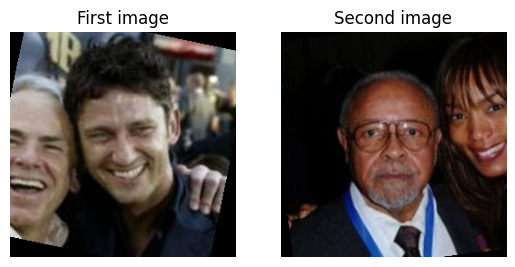

In [8]:
plt.subplot(1, 2, 1)
plt.imshow(x1)
plt.axis('off')
plt.title("First image")

plt.subplot(1, 2, 2)
plt.imshow(x2)
plt.axis('off')
plt.title("Second image")

plt.show()

In [9]:
model.predict(x = [np.expand_dims(x1, axis = 0), np.expand_dims(x2, axis = 0)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


array([[0.03806652]], dtype=float32)

## Optimize the data loader using tensorflow prefetching

In [10]:
#This is how to turn the regular dataloader into a tensorflow dataset with prefetching enabled
#
# dataset = tf.data.Dataset.from_generator(
#         DataLoader, 
#         args = [dataset_root_path, 32, (250, 250)], 
#         output_signature = ((tf.TensorSpec(shape = (32, 250, 250, 3), dtype = tf.float32), tf.TensorSpec(shape = (32, 250, 250, 3), dtype = tf.float32)), tf.TensorSpec(shape = (32, 1), dtype = tf.float32))
# ).prefetch(tf.data.AUTOTUNE)


#Use the function implemented in the Utilities file instead
dataset = get_dataset_with_prefetching(dataset_root_path)
model.fit(dataset, epochs = 3)

Epoch 1/3


180/180 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - accuracy: 0.9705 - loss: 0.1572
Epoch 2/3


/home/thoalfeqar/anaconda3/envs/tf/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


180/180 ━━━━━━━━━━━━━━━━━━━━ 17s 95ms/step - accuracy: 0.9647 - loss: 0.1728
Epoch 3/3
180/180 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9675 - loss: 0.1529
